In [1]:
import sklearn
import numpy as np
import random
import math

from scipy import integrate
from scipy.stats import norm, uniform

In [2]:
class PNNClassifier:
    def __init__(self, isSilent=True):
        if(not isinstance(isSilent, bool)):
            raise TypeError("Expected bool, got " + str(type(isSilent)))
        
        self.X = None
        self.Y = None
        
        self.tmpX = None
        self.tmpY = None
        
        self.n = None
        self.classes = None
        
        self._v = 3
        
        self.classesNum = None
        
        self._cnt = None
        self.prefSumByClass = None
        
        self._resChainK = None
        self._resChainBeta = None
        
        self.isSilent = isSilent
    
    def fit(self, X, Y):
        if(not isinstance(X, np.ndarray)):
            raise TypeError("Expected np.ndarray, got " + str(type(X)))
        if(not isinstance(Y, np.ndarray)):
            raise TypeError("Expected np.ndarray, got " + str(type(Y)))
        if(len(X.shape) != 2):
            raise ValueError("Wrong X shape")
        if(len(Y.shape) != 1):
            raise ValueError("Wrong Y shape")
        if(X.shape[0] != Y.shape[0]):
            raise ValueError("Shapes does not match")

        classes = sorted(np.unique(Y))
        if(classes[0] != 0 or classes[-1] != len(classes) - 1):
            raise ValueError("There should be no empty classes")
        self.classesNum = len(classes)
            
        self.X = np.copy(X)
        self.Y = np.copy(Y)
        
        self.tmpX = np.copy(X)
        self.tmpY = np.copy(Y)
        
        self.n = X.shape[0]
        self._cnt = np.zeros(self.classesNum, dtype=int)
        
        self.prefSumByClass = np.zeros((self.n, self.classesNum, self.n), dtype=int)
        
        for i in range(self.n):
            self._rearrangeData(self.X[i])
            for j in range(self.n):
                self.prefSumByClass[i][self.tmpY[j]][j] += 1
        
        for i in range(self.n):
            for q in range(self.classesNum):
                for j in range(1, self.n):
                    self.prefSumByClass[i][q][j] += self.prefSumByClass[i][q][j - 1]
        
        # Find the best values for k and beta
        # Can take a lot of time
        # So, wait, Carl...
        testing_variance = self._v
        k_chain_first, k_chain_second = [1], [min(1000, self.n - 1)]
        beta_chain_first, beta_chain_second = [10], [0.01]
        
        acceptance_rates_first = [] # just for testing
        acceptance_rates_second = [] # just for testing
        accept_portion = 1000

        
        while True:
            # if we have enough samples, then check if mean and variance of 2 chains are indistinguishable
            if len(k_chain_first) >= accept_portion and len(k_chain_second) >= accept_portion:
                if(not self.isSilent):
                    print("More then 50 samples, so we can check now....")
                    print("---------------------")
                    print("Real acceptance rate(1):", sum(acceptance_rates_first) / len(acceptance_rates_first))
                    print("Real acceptance rate(2):", sum(acceptance_rates_second) / len(acceptance_rates_second))
                    print("---------------------")
                
                k_chain_first = k_chain_first[-accept_portion:]
                beta_chain_first = beta_chain_first[-accept_portion:]
                k_chain_second = k_chain_second[-accept_portion:]
                beta_chain_second = beta_chain_second[-accept_portion:]
                
                # Checking mean and variance
                first_chain_mean = np.mean(np.array([k_chain_first, beta_chain_first]))
                second_chain_mean = np.mean(np.array([k_chain_second, beta_chain_second]))

                first_chain_var = np.var(np.array([k_chain_first, beta_chain_first]))
                second_chain_var = np.var(np.array([k_chain_second, beta_chain_second]))
                
                if(not self.isSilent):
                    print("Mean:", first_chain_mean, second_chain_mean)
                    print("Variance:", first_chain_var, second_chain_var)
                
                    print("Mean for k and last one:", np.mean(np.array(k_chain_first)), np.mean(np.array(k_chain_second)), k_chain_first[-1], k_chain_second[-1])
                    print("Mean for beta and last one:", np.mean(np.array(beta_chain_first)), np.mean(np.array(beta_chain_second)), beta_chain_first[-1], beta_chain_second[-1])
                
                if (second_chain_mean/first_chain_mean) < 1.5 and (first_chain_var/second_chain_var) < 1.5:
                    if(not self.isSilent):
                        print("ACCEPTED!!!!!!!!!")
                    self._resChainK = k_chain_first
                    self._resChainBeta = beta_chain_first

                    break
            
            # For the first chain
            current_k = k_chain_first[-1]
            current_beta = beta_chain_first[-1]
            
            new_k = max(current_k + random.randint(-3, 3), 1)
            new_k = min(self.n - 1, new_k)
            
            new_beta = current_beta + norm.rvs(loc=0, scale=self._v)
            new_beta = abs(new_beta)
                        
            j = float(self._YgivenXBetaK(new_beta, new_k)) / self._YgivenXBetaK(current_beta, current_k)
            j = min(j, 1)
            
            #print("First chain acceptance rate(J):", j, " len:", len(k_chain_first))
            acceptance_rates_first.append(j)
            
            if(random.random() <= j):
                k_chain_first.append(new_k)
                beta_chain_first.append(new_beta)
                
                
            # For the second chain 
            current_k = k_chain_second[-1]
            current_beta = beta_chain_second[-1]
            
            new_k = max(current_k + random.randint(-3, 3), 1)
            new_k = min(self.n - 1, new_k)
            
            new_beta = current_beta + norm.rvs(loc=0, scale=self._v)
            new_beta = abs(new_beta)
            
            j = float(self._YgivenXBetaK(new_beta, new_k)) / self._YgivenXBetaK(current_beta, current_k)
            j = min(j, 1)
            
            #print("Second chain acceptance rate(J):", j, " len:", len(k_chain_second))
            acceptance_rates_second.append(j)
            
            if(random.random() <= j):
                k_chain_second.append(new_k)
                beta_chain_second.append(new_beta)
    

    def _rearrangeData(self, x):
        self.tmpX, self.tmpY = zip(*sorted(zip(self.tmpX, self.tmpY), key = lambda q: np.linalg.norm(x - q[0])))
        
    def _rearrangeRelativeToEachPoint(self):        
        self._rearrangedTrainY = []

        for x in self.X:
            self._rearrangeData(x)
            self._rearrangedTrainY.append(self.tmpY[:])
            
    
    def _YgivenXBetaK(self, beta, k):
        result = 1
        
        beta = float(beta)
        
        for i in range(self.n):
            numerator = self.prefSumByClass[i][self.Y[i]][k] - self.prefSumByClass[i][self.Y[i]][0]
            numerator = math.e ** ((numerator * beta) / k)
            
            denominator = 0
            for q in range(self.classesNum):
                currentDenominator = self.prefSumByClass[i][q][k] - self.prefSumByClass[i][q][0]
                denominator += math.e ** ((currentDenominator * beta) / k)
            
            result *= (float(numerator) / denominator)
        
        return result
    
    def pygivenYXBetaK(self, y, beta, k):
        
        
        beta = float(beta)
        
        numerator = 0
        denominator = 0
        
        for j in range(k):
            if(self.tmpY[j] == y):
                numerator += 1
        
        numerator = math.e ** ((numerator * beta) / k)
        
        self._cnt.fill(0)
            
        for j in range(k):
            self._cnt[self.tmpY[j]] += 1
            
        for item in self._cnt:
            denominator += math.e ** ((item * beta) / k)
        
        return float(numerator) / denominator
    
    def predict_proba(self, X):
        if(self.X is None or self.Y is None):
            raise sklearn.exceptions.NotFittedError("You should fit before predicting")
        if(not isinstance(X, np.ndarray)):
            raise TypeError("Expected np.ndarray, got " + str(type(X)))
        if(X.shape[1] != self.X.shape[1]):
            raise ValueError("Invalid number of features")
        
        res = np.zeros((X.shape[0], self.classesNum), dtype=float)
        
        for i in range(X.shape[0]):
            self._rearrangeData(X[i])
            for j in range(self.classesNum):
                for beta, k in zip(self._resChainBeta, self._resChainK):
                    res[i][j] += self.pygivenYXBetaK(j, beta, k)
                res[i][j] /= float(len(self._resChainK))
        
        return res
        

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
%%time

df = pd.read_csv("./dataset/synth/train.csv")
xTrain = np.array(df[["xs", "ys"]])
yTrain = np.array(df["yc"])

model = PNNClassifier()
model.fit(xTrain, yTrain)

Wall time: 2min 9s


In [6]:
%%time

x = np.linspace(-1, 1, num=50, endpoint=True)
y = np.linspace(-0.2, 1, num=50, endpoint=True)
X, Y = np.meshgrid(x, y)
Z = model.predict_proba(np.c_[X.ravel(), Y.ravel()])[:,0]
Z = Z.reshape(X.shape)

Wall time: 6min 45s


<a list of 6 text.Text objects>

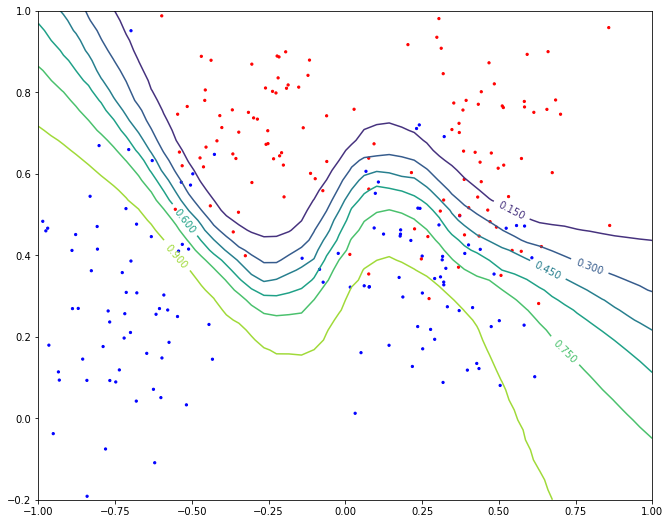

In [7]:
plt.figure(figsize=(11,9))
plt.xlim((-1, 1))
plt.ylim((-0.2, 1))
plt.scatter(xTrain[:,0], xTrain[:,1], c=yTrain, s=5, cmap="bwr")
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)